# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'ybxi_sUZwykyVHe_Bnu5'

In [11]:
# Importing Federal Reserve Economic Data "New Private Housing Units Authorized by Building Permits for the South Atlantic Census Divison" variable
data = quandl.get('FRED/NGDPPOT')

Chose this data as it shows the US GDP which ties into my project.

In [12]:
data.head(5)

,Value
Date,
1949-01-01,274.658161
1949-04-01,275.562222
1949-07-01,277.964165
1949-10-01,281.482290
1950-01-01,284.804425


In [13]:
data.shape

(332, 1)

In [14]:
data.columns

Index(['Value'], dtype='object')

In [15]:
type(data)

pandas.core.frame.DataFrame

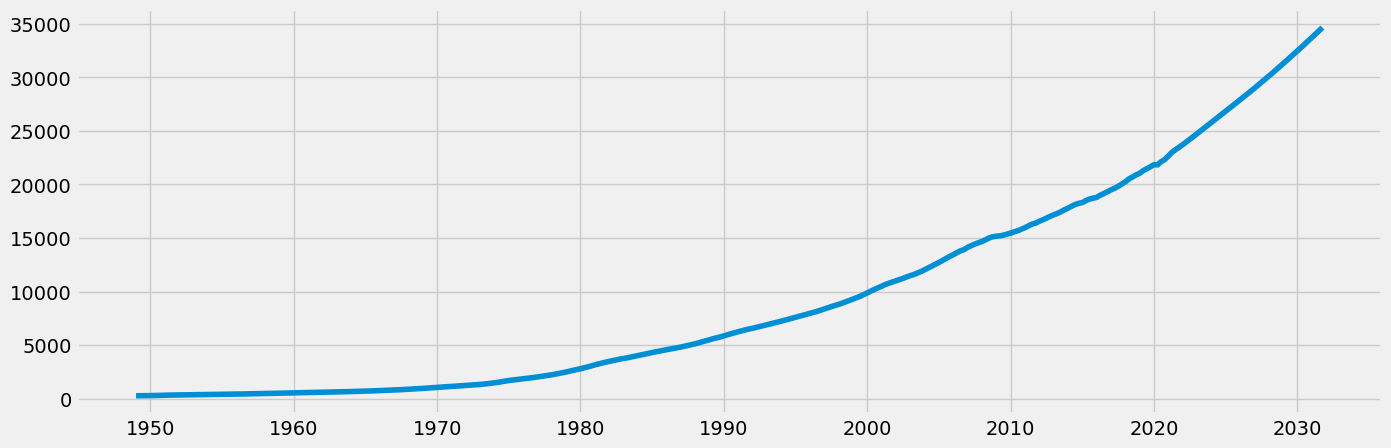

In [16]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [17]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [18]:
data_2.head()

,Date,Value
0,1949-01-01,274.658161
1,1949-04-01,275.562222
2,1949-07-01,277.964165
3,1949-10-01,281.482290
4,1950-01-01,284.804425


In [19]:
data_2.tail()

,Date,Value
327,2030-10-01,33370.53
328,2031-01-01,33682.30
329,2031-04-01,33996.53
330,2031-07-01,34312.95
331,2031-10-01,34631.54


In [20]:
data_sub = data_2.loc[(data_2['Date'] >= '1970-01-01') & (data_2['Date'] < '2031-10-01')]

In [21]:
data_sub.shape

(247, 2)

In [22]:
data_sub.head()

,Date,Value
84,1970-01-01,1052.399806
85,1970-04-01,1076.002570
86,1970-07-01,1093.517230
87,1970-10-01,1116.492069
88,1971-01-01,1142.226922


In [23]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1970-01-01,1052.399806
1970-04-01,1076.002570
1970-07-01,1093.517230
1970-10-01,1116.492069
1971-01-01,1142.226922


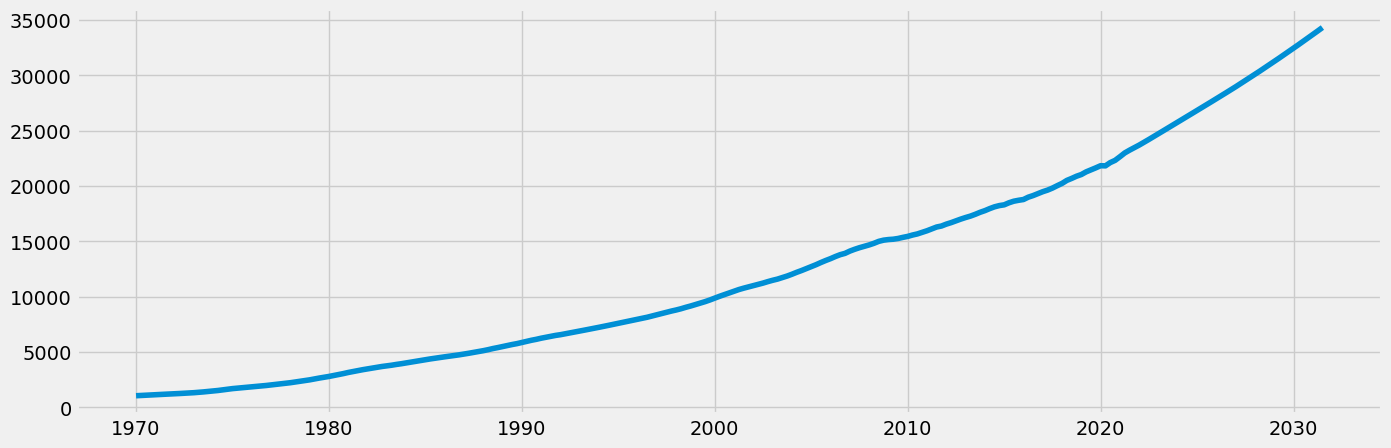

In [24]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

I made a subset starting at 1970 as before this there was not much change.

In [25]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [26]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [27]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [28]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

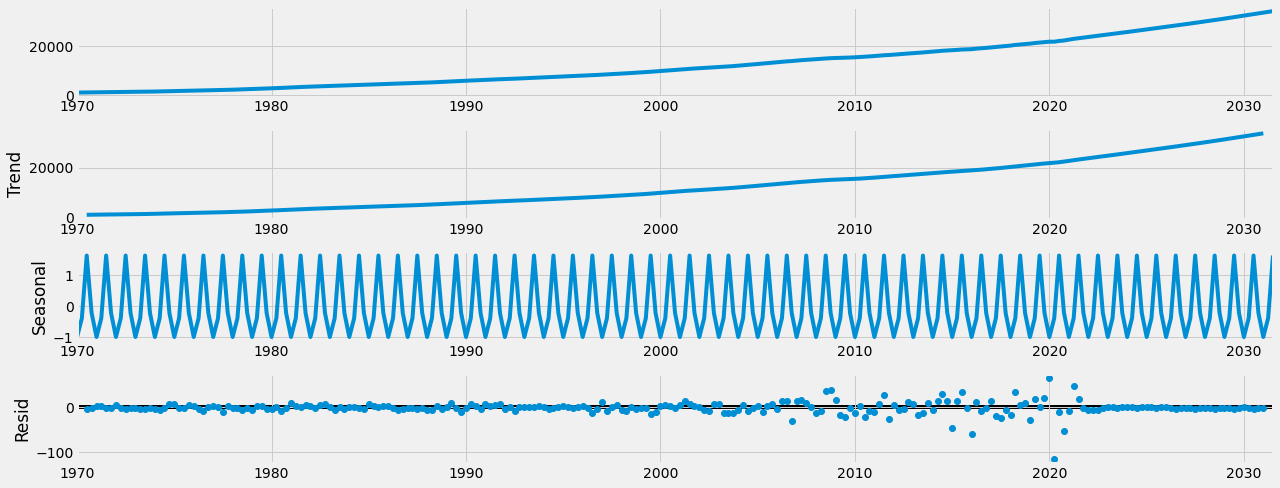

In [29]:
# Plot the separate components

decomposition.plot()
plt.show()

The level and trend are the same so this data is smoothed. The seasonality component displays fluctuations indicating season fluctuations at regular intervals. The residual shows that there isn't too much unexplained noise with a few deviations around 2009 and 2012.

### 4. Testing for stationarity

In [30]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   4.126452
p-value                          1.000000
Number of Lags Used              8.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


The test statistic is way above the critical value. Therefore, you cannot reject the null hypothesis. This indicates that there is a unit root in the data and that the data is likely non-stationary.

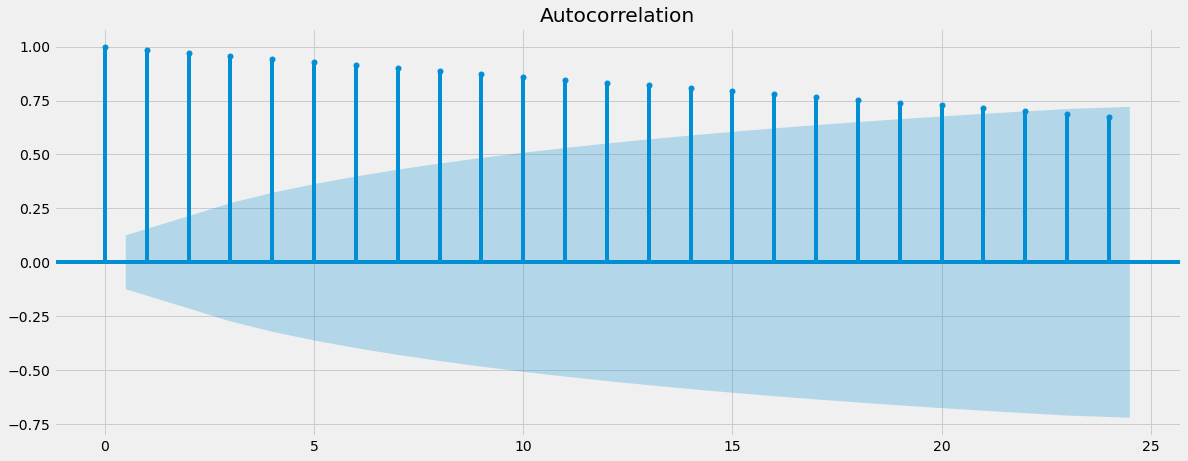

In [31]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The autocorrelation shows that there are many lags beyond the confidence interval likely indicating the data is non-stationary and there is autocorrelated data. The Dickey-Fuller test was correct in stating the data is non-stationary.

### 5. Stationarizing the Federal Reserve Economic Data

In [32]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [33]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [34]:
data_diff.head()

,Value
datetime,
1970-04-01,23.602764
1970-07-01,17.514660
1970-10-01,22.974839
1971-01-01,25.734853
1971-04-01,23.957247


In [35]:
data_diff.columns

Index(['Value'], dtype='object')

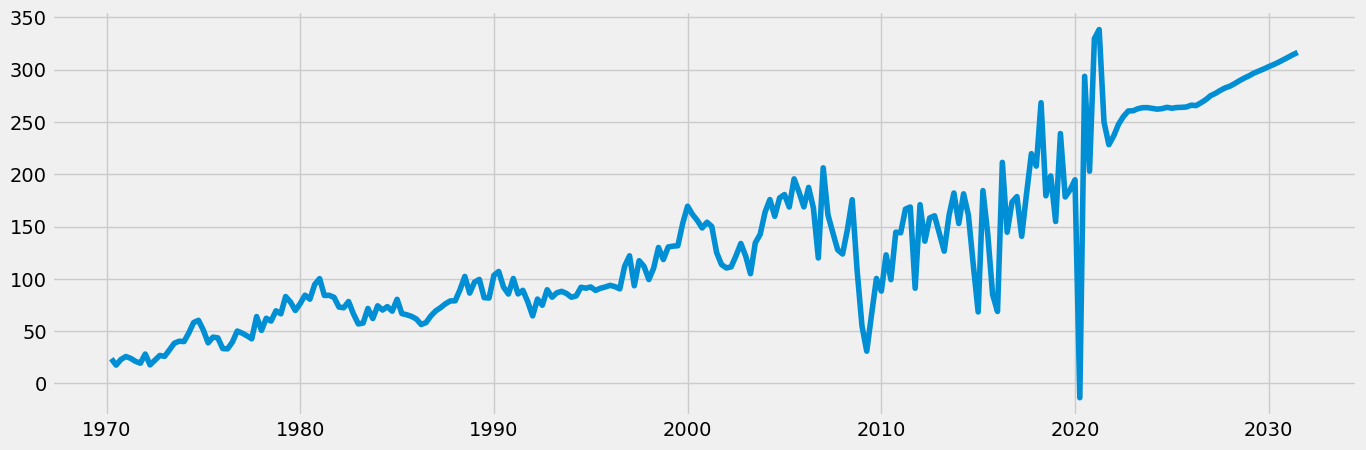

In [36]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [37]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                   0.030704
p-value                          0.960999
Number of Lags Used             10.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


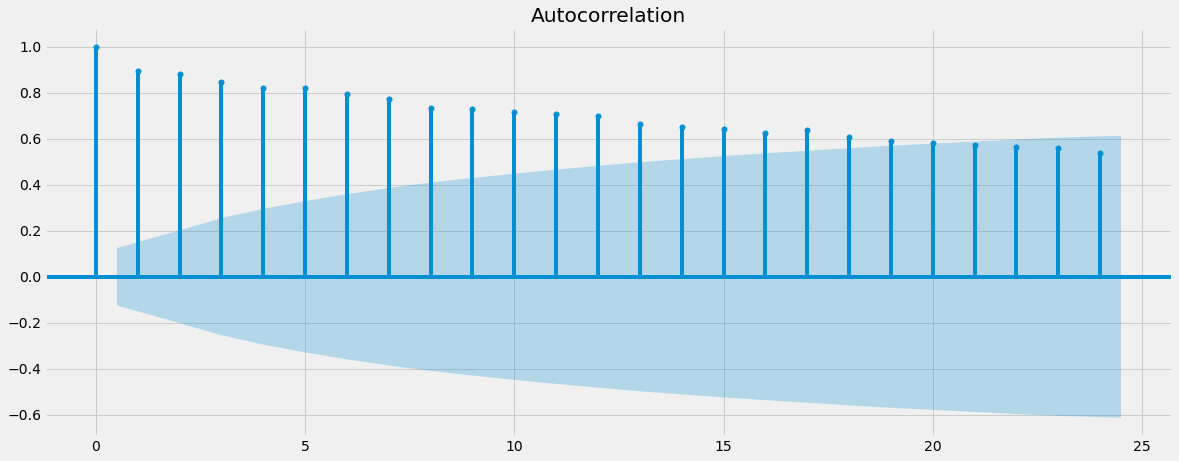

In [38]:
plot_acf(data_diff)
plt.show()

The autocorrelation is significantly different with few autocorrelated terms. However, as there are still lags outside of the confidence interval, it indicates a weak stationarity.